# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import os
from shutil import copyfile

# Functions

In [2]:
def get_sample(data, input_path, output_path, target='movement', 
               n=1000, random_state=123, replace=False, create_directory=False):    
    if target == 'genre':
        data.dropna(axis=0, subset=[target], inplace=True)
    
    sample = data.groupby(by=target).sample(n=n, random_state=random_state, replace=replace)
    
    if create_directory:
        for i, j in sample.iterrows():
            old_path = os.path.join(input_path, j.path)
            new_path = os.path.join(output_path, 
                                    f"{os.path.basename(output_path)}-{target}-{n}",
                                    eval(f"j.{target}"), j.title)
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
            copyfile(old_path,new_path)
        
        sample["path"] = sample[[target,"image"]].apply(lambda x: "/".join(x),axis=1)
        
    return sample

def get_cs_class(csv_path, target):
    return pd.read_csv(os.path.join(csv_path,target + "_class.txt"), header=None, delim_whitespace=True)
    
def get_cs_train_val(csv_path, target, class_=None):
    
    if not isinstance(class_, pd.DataFrame):
        class_ = get_cs_class(csv_path, target)
        
    cs_train = pd.read_csv(os.path.join(csv_path, target + "_train.csv"), header=None)
    cs_train["split"] = "train"
    
    cs_val = pd.read_csv(os.path.join(csv_path, target + "_val.csv"), header=None)
    cs_val["split"] = "val"
    
    cs = pd.concat([cs_train, cs_val], ignore_index=True)
    cs.columns = ["path", target + "_id", "cs-split-" + target]
        
    cs[target] = cs[target + "_id"].apply(lambda x: class_.loc[x][1])
    cs["style-from-path"] = cs["path"].apply(lambda x: x.split('/')[0])
    cs["artist-from-path"] = cs["path"].apply(lambda x: x.split('/')[1].split('_')[0])
    cs["title-from-path"] = cs["path"].apply(lambda x: x.split('/')[1].split('_')[1])
    
    return cs

def get_data(csv_path, image_path, rm_duplicate=True):
    
    cs_style = get_cs_train_val(csv_path, 'style')
    cs_genre = get_cs_train_val(csv_path, 'genre')
    cs_artist = get_cs_train_val(csv_path, 'artist')

    # There is one duplicata inside genre_train.csv / genre_test.csv
    # One image labelled with two genres
    if rm_duplicate:
        if not cs_genre[cs_genre["path"].duplicated(keep='first')].empty:
            cs_genre.drop(cs_genre[cs_genre["path"].duplicated(keep='first')].index, 
                          inplace=True)
             
    movement_list = [i for i in os.listdir(image_path) 
                     if i != '.DS_Store']
    
    movement = []
    image = []
    artist = []
    title = []
    path = []
    
    for g in movement_list:
        files = os.listdir(os.path.join(image_path,g))
        movement.extend([g]*len(files))
        image.extend(files)
        artist.extend(list(map(lambda x: x.split('_')[0], files)))
        title.extend(list(map(lambda x: x.split('_')[1], files)))
        path.extend(list(map(lambda x: g + '/' + x, files)))
    
    data = pd.DataFrame({"path": path, "movement": movement, "artist": artist, "title": title, "image": image})
    
    data = data.merge(cs_genre[["path", "genre", "cs-split-genre"]], on="path",  how="outer")
    data = data.merge(cs_style[["path", "cs-split-style"]], on="path",  how="outer")
    data = data.merge(cs_artist[["path", "cs-split-artist"]], on="path",  how="outer")

    return data

# Get Data

In [3]:
csv_path = "../raw_data/wikiart"
image_path= "../raw_data/wikiart/wikiart"
sample_path = "../raw_data/wikiart"

In [4]:
data = get_data(csv_path, image_path)

In [5]:
data.head()

path           movement  \
0     Early_Renaissance/filippo-lippi_two-saints.jpg  Early_Renaissance   
1  Early_Renaissance/filippo-lippi_madonna-del-ce...  Early_Renaissance   
2  Early_Renaissance/piero-della-francesca_annunc...  Early_Renaissance   
3  Early_Renaissance/pietro-perugino_christ-in-th...  Early_Renaissance   
4  Early_Renaissance/antonello-da-messina_madonna...  Early_Renaissance   

                  artist                                  title  \
0          filippo-lippi                         two-saints.jpg   
1          filippo-lippi                  madonna-del-ceppo.jpg   
2  piero-della-francesca               annunciation-1464(1).jpg   
3        pietro-perugino     christ-in-the-sarcophagus-1473.jpg   
4   antonello-da-messina  madonna-and-child-salting-madonna.jpg   

                                               image               genre  \
0                       filippo-lippi_two-saints.jpg  religious_painting   
1                filippo-lippi_madonna-del-ceppo.jpg  religious_painting   
2     piero-della-francesca_annunciation-1464(1).jpg  religious_painting   
3  pietro-perugino_christ-in-the-sarcophagus-1473...  religious_painting   
4  antonello-da-messina_madonna-and-child-salting...  religious_painting   

  cs-split-genre cs-split-style cs-split-artist  
0            val            val             NaN  
1          train          train             NaN  
2          train          train             NaN  
3          train          train             NaN  
4            val            val             NaN

In [ ]:
sample = get_sample(data, image_path, sample_path, target='genre', n=5, random_state=123, 
                    replace=False, create_directory=True)    


In [ ]:
sample.head()

In [6]:
data['genre'].isnull().sum()

16452

# Data Visualization

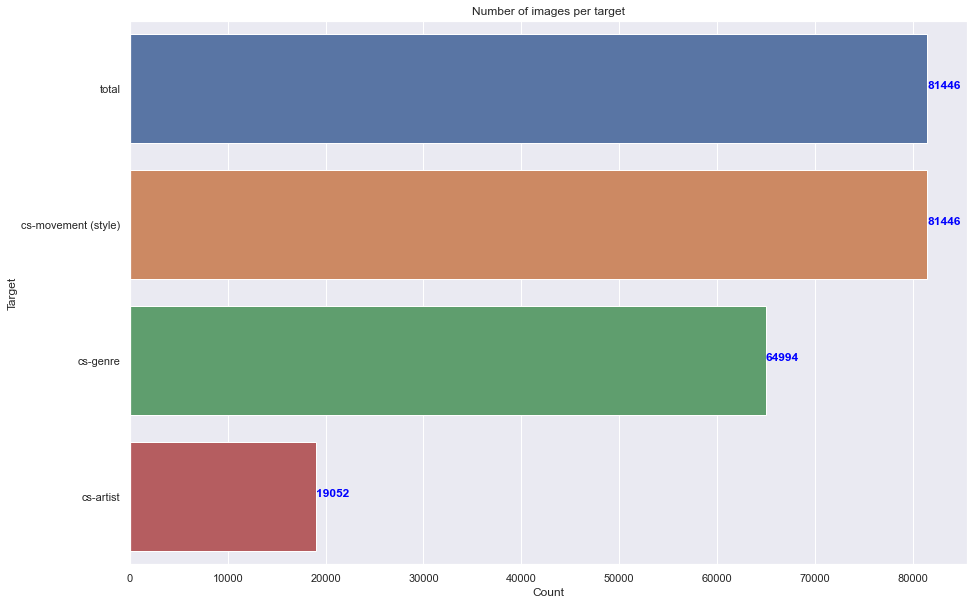

In [7]:
col = ['cs-split-artist','cs-split-genre','cs-split-style','path']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].count().index, 
            x=data[col].count().values,
            order=data[col].count().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].count().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_yticklabels(['total','cs-movement (style)','cs-genre','cs-artist']);
ax.set_title("Number of images per target");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

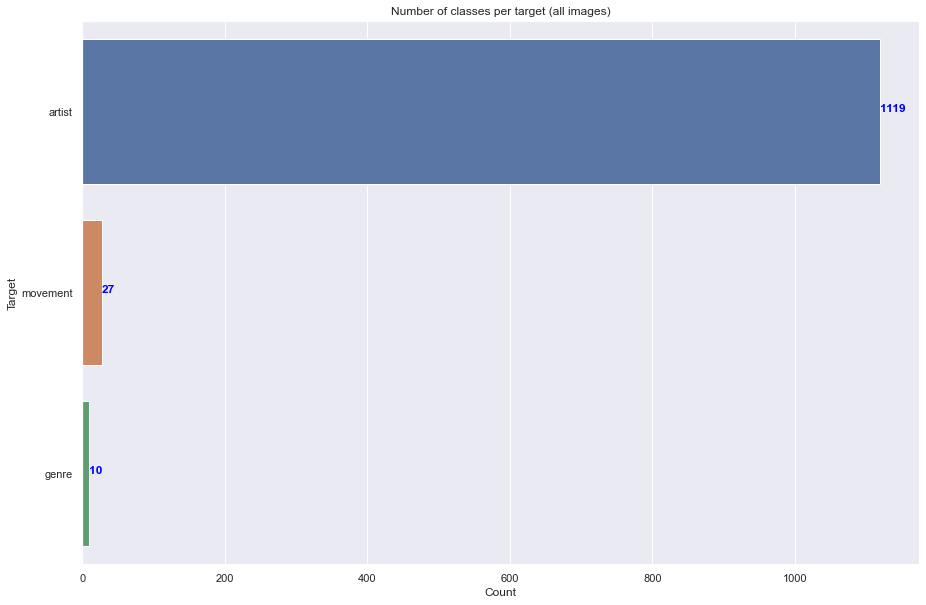

In [8]:
col = ['artist','genre','movement']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].nunique().index, 
            x=data[col].nunique().values,
            order=data[col].nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of classes per target (all images)");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

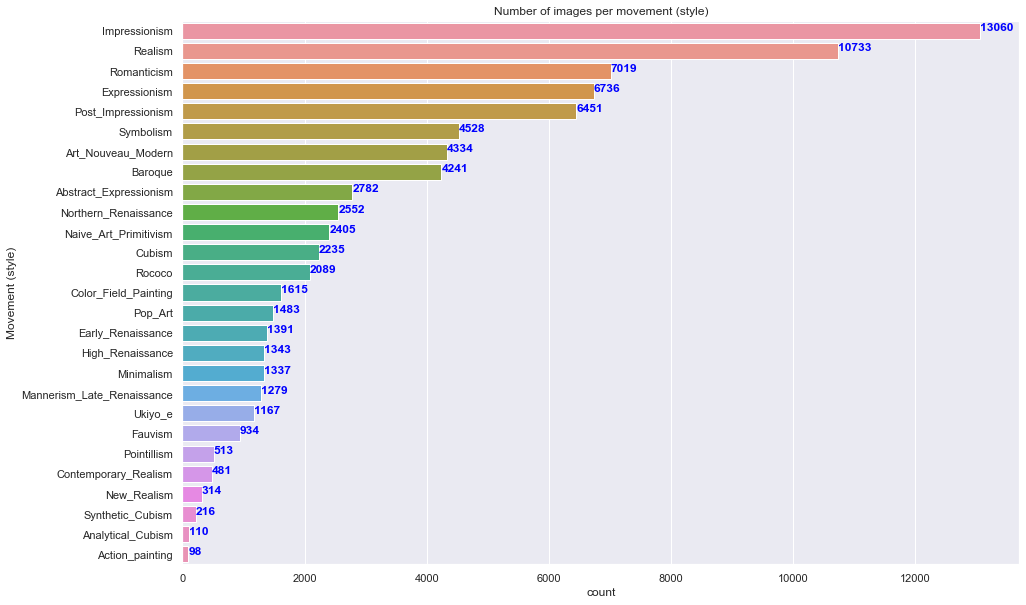

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="movement", 
              order = data['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per movement (style)");
ax.set_ylabel("Movement (style)");

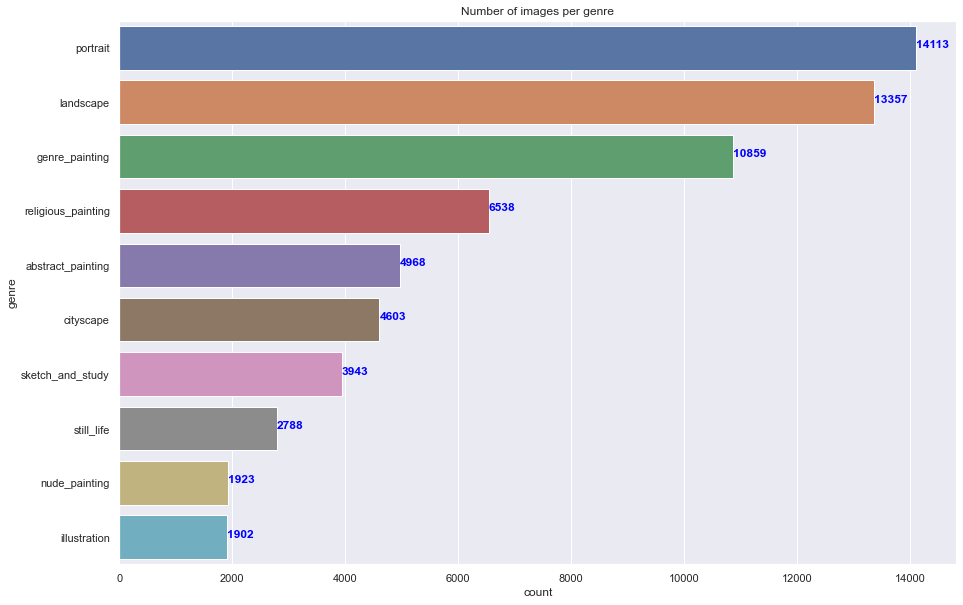

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="genre", 
              order = data['genre'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["genre"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per genre");

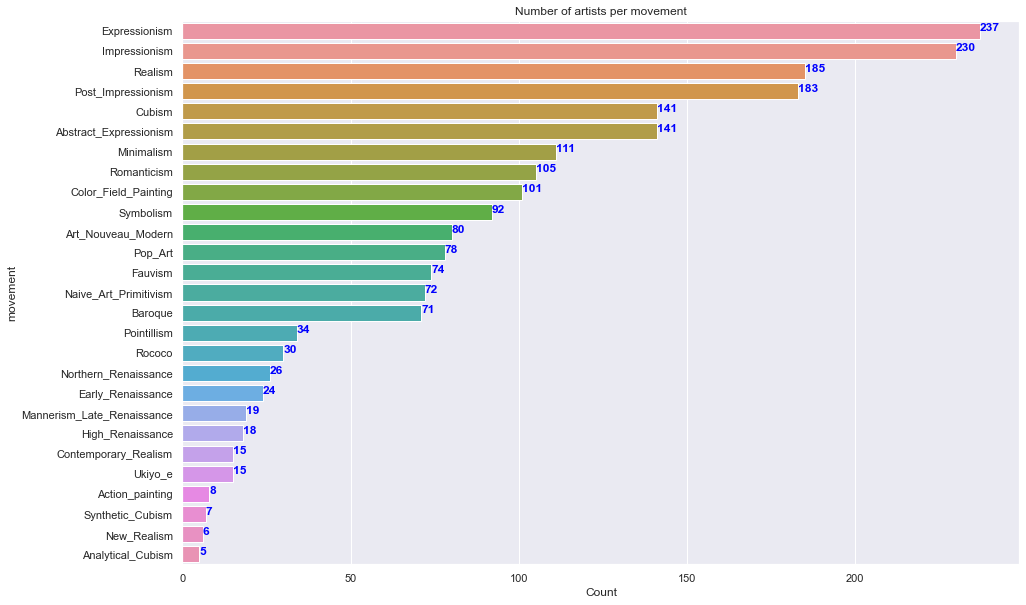

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.barplot(y=data.groupby("movement").artist.nunique().index, 
            x=data.groupby("movement").artist.nunique().values,
            order=data.groupby("movement").artist.nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data.groupby("movement").artist.nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of artists per movement");
ax.set_xlabel("Count");


# Sampling viz

In [29]:
#Proposition for movements merging

merge1=['Abstract_Expressionism','Action_painting','Color_Field_Painting']
merge2=['Analytical_Cubism','Cubism','Synthetic_Cubism']
merge3=['Rococo','Baroque']
merge4=['Early_Renaissance','High_Renaissance','Mannerism_Late_Renaissance','Northern_Renaissance']
merge5=['Impressionism','Post_Impressionism','Symbolism']

In [31]:
#isolation of df to quick check similarities :
df1=data[data.movement.isin(merge1)]
df2=data[data.movement.isin(merge2)]
df3=data[data.movement.isin(merge3)]
df4=data[data.movement.isin(merge4)]
df5=data[data.movement.isin(merge5)]


In [78]:
#Show random pictures in a dataframe

def show_samples(df,sample_size=10):
    
    root_path='../raw_data/wikiart/wikiart/'
    sample=df.sample(n=sample_size).reset_index()

    folder_path=list(sample['path'])
    fig = plt.figure(constrained_layout=True,figsize=(10,5*sample_size))
    
    for i in list(range(0,sample_size)):
        artist=sample['artist'][i]
        movement=sample['movement'][i]
        title=sample['title'][i]
        path=root_path+sample['path'][i]
        
        plt.subplot(sample_size,1,i+1)
        image=plt.imread(path)
        label=f'{movement} - {title} by {artist}'
        plt.text(x=10,y=-2,s=label)
        plt.imshow(image)
        
    

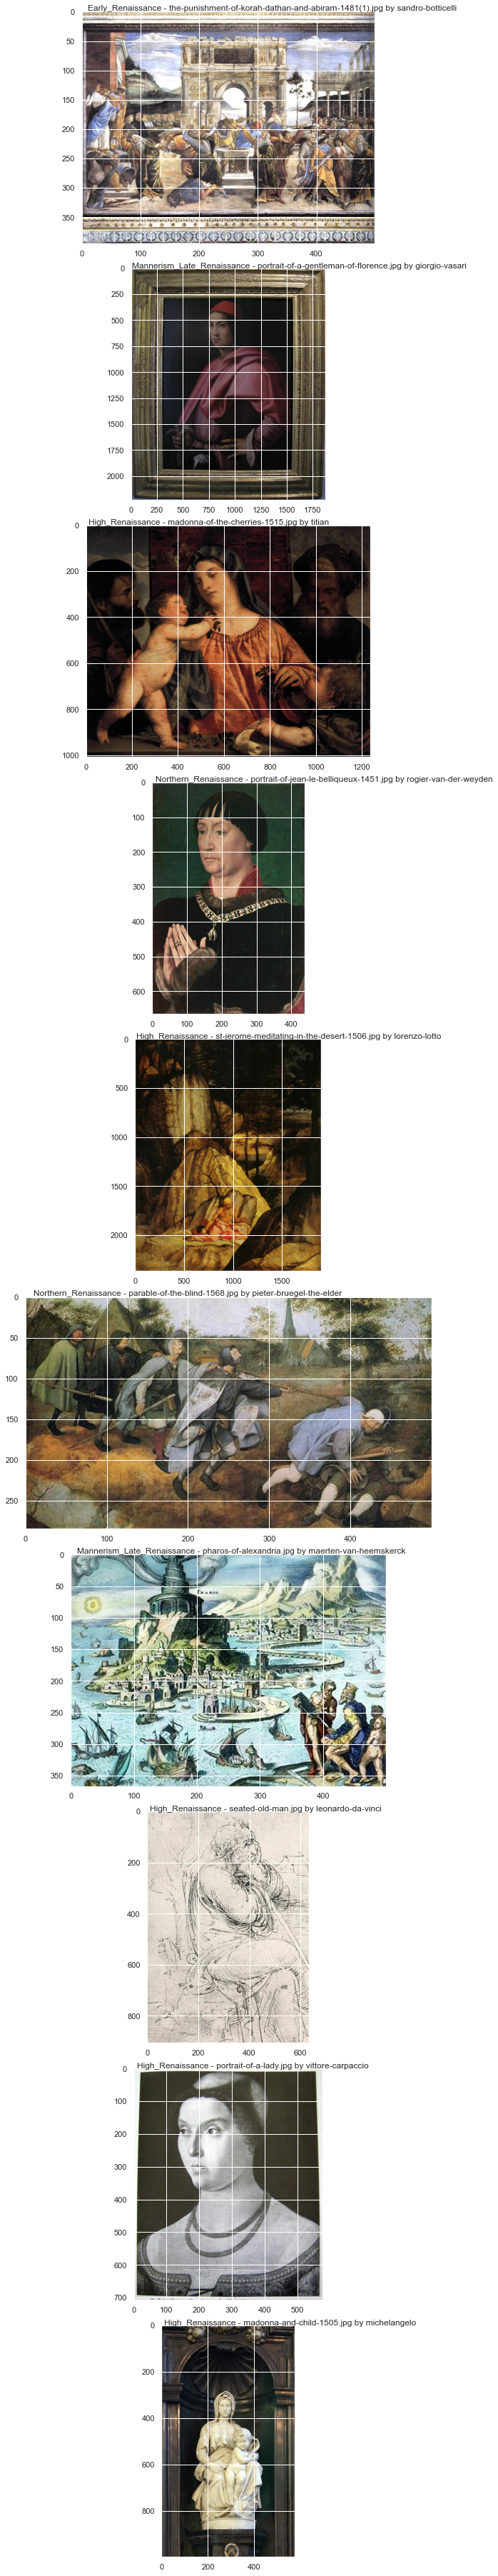

In [79]:
show_samples(df4)

In [82]:
#only empty genre to check if the content is limited to sculptures

empty_genre=data[data['genre'].isnull()].reset_index()

empty_genre.head()

index                                               path  \
0      6  Early_Renaissance/andrea-mantegna_the-battle-o...   
1     15  Early_Renaissance/andrea-del-verrocchio_giulia...   
2     24  Early_Renaissance/andrea-del-castagno_the-cuma...   
3     31  Early_Renaissance/donatello_judith-and-holofer...   
4     52  Early_Renaissance/donatello_virgin-and-child-w...   

            movement                 artist  \
0  Early_Renaissance        andrea-mantegna   
1  Early_Renaissance  andrea-del-verrocchio   
2  Early_Renaissance    andrea-del-castagno   
3  Early_Renaissance              donatello   
4  Early_Renaissance              donatello   

                                   title  \
0        the-battle-of-sea-gods-1480.jpg   
1            giuliano-de-medici-1478.jpg   
2                    the-cuman-sibyl.jpg   
3         judith-and-holofernes-1460.jpg   
4  virgin-and-child-with-four-angels.jpg   

                                               image genre cs-split-genre  \
0    andrea-mantegna_the-battle-of-sea-gods-1480.jpg   NaN            NaN   
1  andrea-del-verrocchio_giuliano-de-medici-1478.jpg   NaN            NaN   
2            andrea-del-castagno_the-cuman-sibyl.jpg   NaN            NaN   
3           donatello_judith-and-holofernes-1460.jpg   NaN            NaN   
4    donatello_virgin-and-child-with-four-angels.jpg   NaN            NaN   

  cs-split-style cs-split-artist  
0          train             NaN  
1          train             NaN  
2            val             NaN  
3          train             NaN  
4            val             NaN

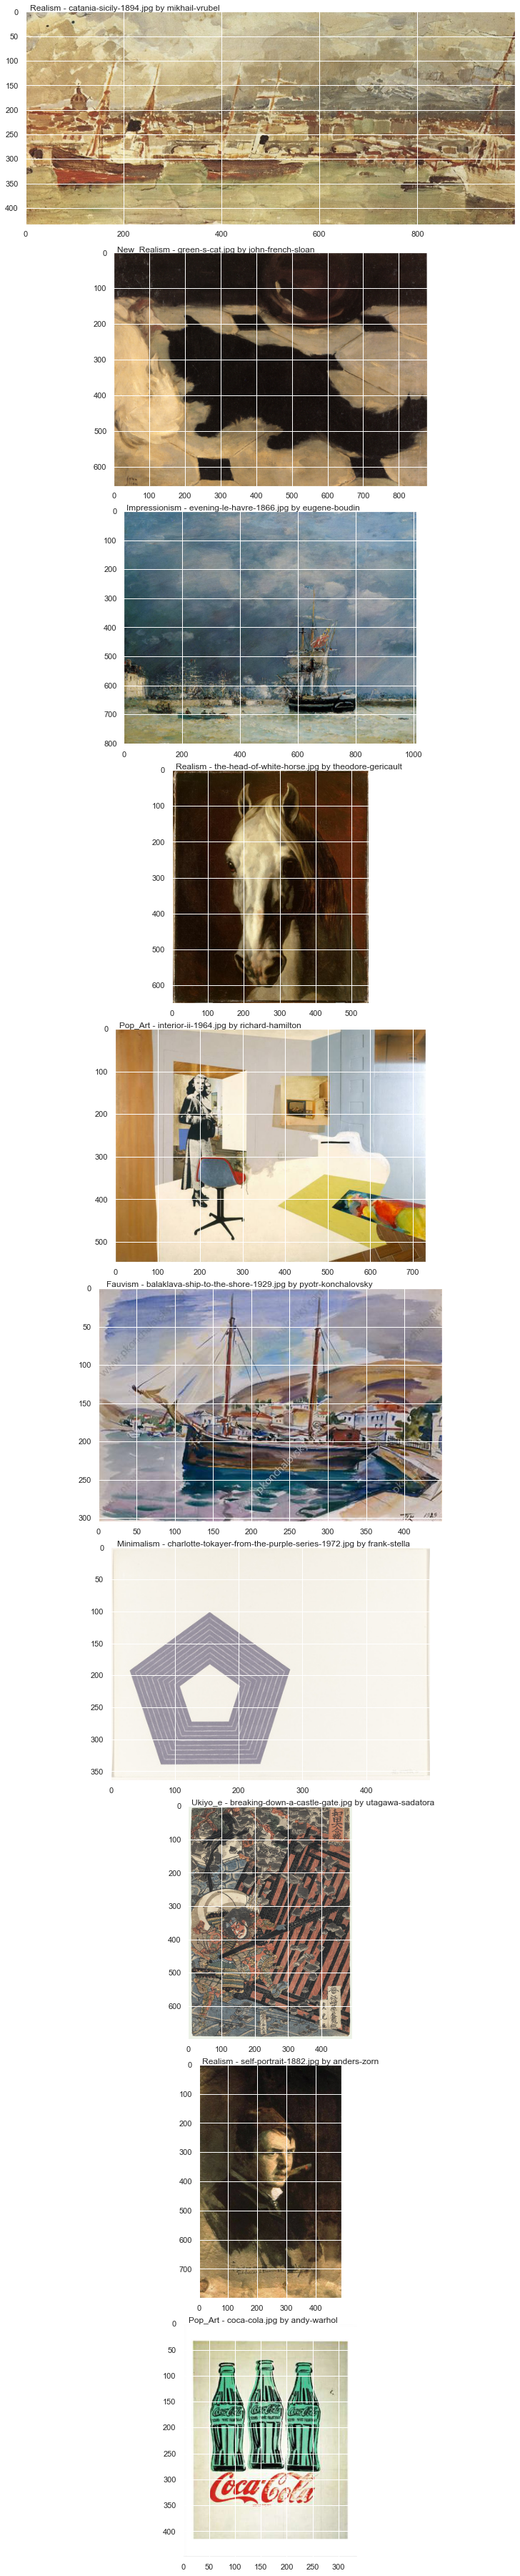

In [83]:
show_samples(empty_genre,10)